# Resource usage - exploratory analysis

#### Maria Silva, March 2025

## 1. Imports and settings

Let's start by importing the necessary libraries and setting up some directories and files.


In [1]:
import os
import sys
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Main directories and files
current_path = os.getcwd()
repo_dir = os.path.abspath(os.path.join(current_path, ".."))
src_dir = os.path.join(repo_dir, "src")
data_dir = os.path.join(repo_dir, "data")
op_files_dir = os.path.join(data_dir, "aggregated_opcodes", "*", "file.parquet")

In [3]:
# import internal packages
sys.path.append(src_dir)
from opcode_resource import split_opcode_gas_by_resource

## 2. Load data

Now, let's load the data. We will start by loading the opcodes used for blocks 22000000 to 22001999.

In [4]:
# Load parquet files with duckdb
query = f"""
SELECT block_height, tx_hash, op, gasCost_v2 AS op_gas_cost, op_count AS op_gas_pair_count
FROM read_parquet(
    '{op_files_dir}', 
    hive_partitioning=True, 
    filename=True,
    file_row_number=True,
    union_by_name=True
    )
WHERE block_height BETWEEN 22000000 AND 22001999;
"""
raw_usage_df = duckdb.connect().execute(query).fetchdf()
# Print info
raw_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13518258 entries, 0 to 13518257
Data columns (total 5 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   block_height       int64 
 1   tx_hash            object
 2   op                 object
 3   op_gas_cost        int64 
 4   op_gas_pair_count  int64 
dtypes: int64(3), object(2)
memory usage: 515.7+ MB


In [5]:
raw_usage_df["block_height"].agg(["min", "max"])

min    22000020
max    22001999
Name: block_height, dtype: int64

Now, we can load the gas used per transaction for the same blocks.

In [6]:
raw_tx_gas_usage_df = pd.read_parquet(
    os.path.join(data_dir, "tx_gas_usage_22000000_22001999.parquet")
)
raw_tx_gas_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290953 entries, 0 to 290952
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   block_height           290953 non-null  int64 
 1   transaction_hash       290953 non-null  object
 2   gas_used               290953 non-null  int64 
 3   n_input_zero_bytes     290953 non-null  int64 
 4   n_input_nonzero_bytes  290953 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 11.1+ MB


## 3. Process data

In [7]:
# Filter desired blocks
tx_gas_usage_df = raw_tx_gas_usage_df.copy()
# Compute input data gas cost
tx_gas_usage_df["tx_input_data_gas_cost"] = (
    4.0 * tx_gas_usage_df["n_input_zero_bytes"]
    + 16.0 * tx_gas_usage_df["n_input_nonzero_bytes"]
)
# Clean up columns
tx_gas_usage_df = tx_gas_usage_df.drop(
    columns=["block_height", "n_input_zero_bytes", "n_input_nonzero_bytes"]
)
tx_gas_usage_df.columns = ["tx_hash", "tx_gas_cost", "tx_input_data_gas_cost"]
# Print info
tx_gas_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290953 entries, 0 to 290952
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   tx_hash                 290953 non-null  object 
 1   tx_gas_cost             290953 non-null  int64  
 2   tx_input_data_gas_cost  290953 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.7+ MB


In [8]:
# Add total transaction gas
usage_df = raw_usage_df.merge(tx_gas_usage_df, on="tx_hash", how="left")
# Add new opcode for transactions with no opcodes
usage_df["op_gas_cost"] = np.where(
    usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"]),
    usage_df["tx_gas_cost"] - usage_df["tx_input_data_gas_cost"] - 21000.0,
    usage_df["op_gas_cost"],
)
# Clean up repeated opcodes
usage_df["op"] = np.where(usage_df["op"].str.startswith("DUP"), "DUP", usage_df["op"])
usage_df["op"] = np.where(usage_df["op"].str.startswith("SWAP"), "SWAP", usage_df["op"])
usage_df["op"] = np.where(
    (usage_df["op"].str.startswith("PUSH")) & (usage_df["op"] != "PUSH0"),
    "PUSH",
    usage_df["op"],
)
# Compute total gas cost for opcode
usage_df["op_total_gas_cost"] = usage_df["op_gas_cost"] * usage_df["op_gas_pair_count"]
# Print info
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13518258 entries, 0 to 13518257
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   block_height            int64  
 1   tx_hash                 object 
 2   op                      object 
 3   op_gas_cost             float64
 4   op_gas_pair_count       int64  
 5   tx_gas_cost             int64  
 6   tx_input_data_gas_cost  float64
 7   op_total_gas_cost       float64
dtypes: float64(3), int64(3), object(2)
memory usage: 825.1+ MB


In [9]:
op_tx_df = (
    usage_df.groupby(["block_height", "tx_hash"])
    .agg(
        {
            "op_total_gas_cost": "sum",
            "tx_gas_cost": "first",
            "tx_input_data_gas_cost": "first",
        }
    )
    .reset_index()
)
op_tx_df.columns = [
    "block_height",
    "tx_hash",
    "op_gas_cost",
    "tx_gas_cost",
    "tx_input_data_cost",
]
op_tx_df["tx_gas_refund_estimated"] = (
    op_tx_df["op_gas_cost"] + op_tx_df["tx_input_data_cost"] + 21000.0
) - op_tx_df["tx_gas_cost"]
op_tx_df["is_op_gas_correct"] = (op_tx_df["tx_gas_refund_estimated"] >= 0) & (
    np.abs(op_tx_df["tx_gas_refund_estimated"] / op_tx_df["tx_gas_cost"]) < 0.2
)
op_tx_df.head()

,block_height,tx_hash,op_gas_cost,tx_gas_cost,tx_input_data_cost,tx_gas_refund_estimated,is_op_gas_correct
0,22000020,0x029c1f067919e7ef9387862fa0624b98a2a3624ec581...,141594.0,160530,736.0,2800.0,True
1,22000020,0x0395c4139f9b563fe264651b47699842a6fdaf704cbe...,51859.0,105495,2136.0,-30500.0,False
2,22000020,0x050ff26618ce1c10b47644ac628e3648e96c6b217d25...,0.0,21064,64.0,0.0,True
3,22000020,0x070584ade4418b6cffa46b54888d33a86f44f1359e78...,0.0,21000,0.0,0.0,True
4,22000020,0x0786a329bb718b8afc44465662b6546273eac1d6e728...,8130.0,24890,560.0,4800.0,True


## 4. Split op usage by resource type

In [21]:
# Apply resource split rule to each row
op_gas_by_resource = usage_df.apply(
    lambda x: split_opcode_gas_by_resource(x["op"], x["op_gas_cost"], x["tx_hash"]),
    axis=1,
).tolist()

In [33]:
# Aggregate by tx_hash and sum up the resources
op_gas_by_resource_df = (
    pd.DataFrame(op_gas_by_resource)
    .drop(columns=["op"])
    .groupby("tx_hash")
    .sum()
    .reset_index()
)

# Add tx instrinsic cost to compute -> BIG assumption!
op_gas_by_resource_df["compute"] += 21000.0

# Join with op_tx_df
temp_op_tx_df = op_tx_df.drop(columns=["op_gas_cost"])
op_gas_by_resource_df = op_gas_by_resource_df.merge(
    temp_op_tx_df, on="tx_hash", how="left"
)

# Fix rows with incorrect opcode gas calculations -> assume everything is unassigned
#  (except the intrinsic cost) and ignore gas refunds
op_gas_by_resource_df["unassigned"] = np.where(
    op_gas_by_resource_df["is_op_gas_correct"],
    op_gas_by_resource_df["unassigned"],
    op_gas_by_resource_df["tx_gas_cost"] - op_gas_by_resource_df["tx_input_data_cost"]-21000.0,
)
op_gas_by_resource_df["compute"] = np.where(
    op_gas_by_resource_df["is_op_gas_correct"],
    op_gas_by_resource_df["compute"],
    21000.0,
)
op_gas_by_resource_df["memory"] = np.where(
    op_gas_by_resource_df["is_op_gas_correct"],
    op_gas_by_resource_df["memory"],
    0.0,
)
op_gas_by_resource_df["access"] = np.where(
    op_gas_by_resource_df["is_op_gas_correct"],
    op_gas_by_resource_df["access"],
    0.0,
)
op_gas_by_resource_df["history_growth"] = np.where(
    op_gas_by_resource_df["is_op_gas_correct"],
    op_gas_by_resource_df["history_growth"],
    0.0,
)
op_gas_by_resource_df["bloom_topics"] = np.where(
    op_gas_by_resource_df["is_op_gas_correct"],
    op_gas_by_resource_df["bloom_topics"],
    0.0,
)
op_gas_by_resource_df["state_growth"] = np.where(
    op_gas_by_resource_df["is_op_gas_correct"],
    op_gas_by_resource_df["state_growth"],
    0.0,
)
op_gas_by_resource_df["tx_gas_refund_estimated"] = np.where(
    op_gas_by_resource_df["is_op_gas_correct"],
    op_gas_by_resource_df["tx_gas_refund_estimated"],
    0.0,
)

# Check result
op_gas_by_resource_df.head()

,tx_hash,compute,memory,access,unassigned,history_growth,bloom_topics,state_growth,block_height,tx_gas_cost,tx_input_data_cost,tx_gas_refund_estimated,is_op_gas_correct
0,0x00003ef2732f7a5fae9e941735730033b0b9158f352d...,21493.0,2639.0,2000.0,2900.0,986.0,750.0,0.0,22000219,40360,608.0,4800.0,True
1,0x0000660566258dcad219705056675861f779e7726e52...,21220.0,6724.0,2500.0,0.0,1248.0,250.0,0.0,22000622,32650,512.0,0.0,True
2,0x000090840558d73b755fa6520b6b14e4a0e477db8608...,21000.0,0.0,0.0,0.0,0.0,0.0,0.0,22001353,21000,0.0,0.0,True
3,0x0000d156c77b4b2cd777dded82d69a38173ff5d7fc4d...,21000.0,0.0,0.0,0.0,0.0,0.0,0.0,22000783,21000,0.0,0.0,True
4,0x00016a4bd16a81c927552beb290952430b7a22dd7d39...,21000.0,0.0,0.0,87716.0,0.0,0.0,0.0,22000326,110080,1364.0,0.0,False


## 5. Block utilization

In [38]:
block_utilization_df = (
    op_gas_by_resource_df.drop(columns=["tx_hash"])
    .groupby("block_height")
    .sum()
    .reset_index()
)
block_utilization_df

,block_height,compute,memory,access,unassigned,history_growth,bloom_topics,state_growth,tx_gas_cost,tx_input_data_cost,tx_gas_refund_estimated,is_op_gas_correct
0,22000020,2087066.0,218807.0,126000.0,18218324.0,92545.0,46500.0,0.0,25700042,2852660.0,169600.0,86
1,22000021,2059993.0,240735.0,197500.0,4533782.0,148150.0,72000.0,0.0,11418650,953220.0,480200.0,90
2,22000022,2498510.0,223722.0,171000.0,11095269.0,143730.0,64000.0,0.0,20201059,853880.0,319300.0,105
3,22000023,1562261.0,163991.0,136500.0,8242658.0,81788.0,43500.0,0.0,15766028,373472.0,396600.0,64
4,22000024,2509783.0,96401.0,163000.0,13996721.0,101880.0,58500.0,0.0,20465440,1444076.0,289200.0,115
...,...,...,...,...,...,...,...,...,...,...,...,...
1972,22001995,4477883.0,758066.0,562000.0,4719994.0,377150.0,186750.0,0.0,17875640,362672.0,1198900.0,194
1973,22001996,3901360.0,573563.0,483000.0,4564522.0,377594.0,165500.0,0.0,16547813,302412.0,1095200.0,164
1974,22001997,3487096.0,548052.0,431500.0,6101516.0,338853.0,144250.0,0.0,17313666,506120.0,919500.0,141
1975,22001998,267923.0,110288.0,84500.0,213000.0,57531.0,26000.0,0.0,1777161,31344.0,207200.0,12


/var/folders/mn/rdhdzml11dxgb7ghz0n9h1980000gn/T/ipykernel_20093/3823964603.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


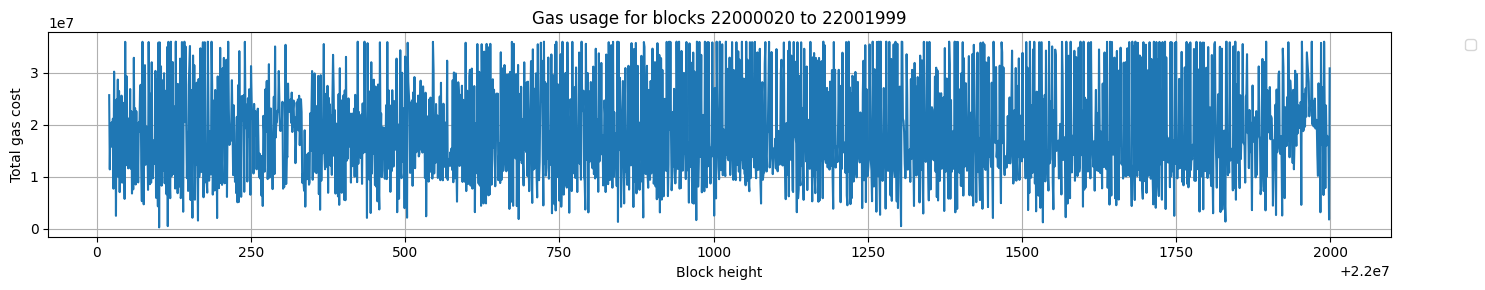

In [59]:
plt.figure(figsize=(15, 3))
plt.grid()
sns.lineplot(data=block_utilization_df, x="block_height", y="tx_gas_cost")

plt.xlabel("Block height")
plt.ylabel("Total gas cost")
plt.title("Gas usage for blocks 22000020 to 22001999")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

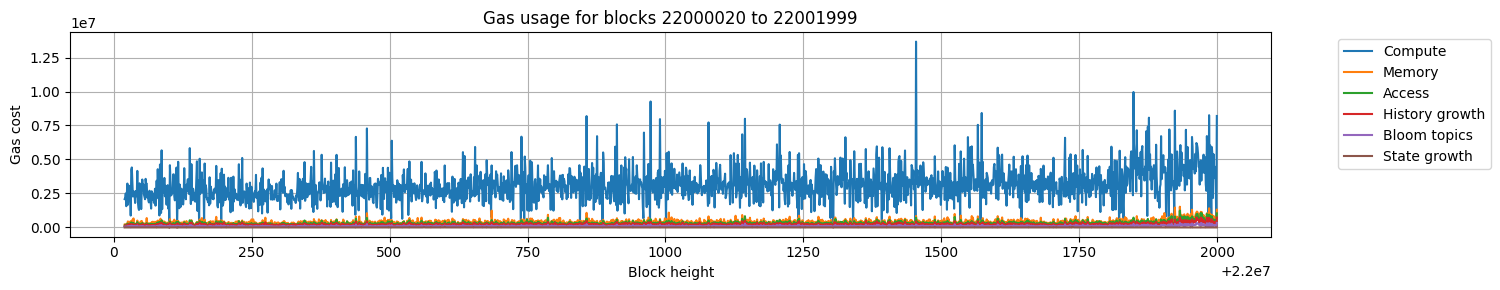

In [60]:
plt.figure(figsize=(15, 3))
plt.grid()
sns.lineplot(data=block_utilization_df, x="block_height", y="compute", label="Compute")
sns.lineplot(data=block_utilization_df, x="block_height", y="memory", label="Memory")
sns.lineplot(data=block_utilization_df, x="block_height", y="access", label="Access")
sns.lineplot(data=block_utilization_df, x="block_height", y="history_growth", label="History growth")
sns.lineplot(data=block_utilization_df, x="block_height", y="bloom_topics", label="Bloom topics")
sns.lineplot(data=block_utilization_df, x="block_height", y="state_growth", label="State growth")

plt.xlabel("Block height")
plt.ylabel("Gas cost")
plt.title("Gas usage for blocks 22000020 to 22001999")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()